In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage      
import sklearn.feature_extraction.text as sk_text
import sklearn.cluster as sk_cluster
import sklearn.metrics as metrics
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
import datetime
startTime = datetime.datetime.now()
print(str(startTime))

In [ ]:
tweets = pd.read_csv('clean_data.csv')
tweets['FrequencyOver20'] = tweets.FrequencyOver20.str.lower()
#print initial data
tweets.head()

In [ ]:
aggregateTweetsHashtags =tweets.groupby('UserID')['FrequencyOver20'].apply(lambda x: x.str.cat(sep=' '))
tweetsPrepareSKText = pd.DataFrame({'User_id': aggregateTweetsHashtags.index, 'All_hashtags': aggregateTweetsHashtags.values})
vectorizer = sk_text.TfidfVectorizer(max_features = 100,
                             min_df=100, 
                             #max_df=100000,
                             stop_words = 'english'
                             )


In [ ]:
matrix = vectorizer.fit_transform(tweetsPrepareSKText.All_hashtags.values)
tdidf = matrix.toarray()
df_text = pd.DataFrame(matrix.todense(), index=aggregateTweetsHashtags.index, columns=vectorizer.get_feature_names())
df_text.head()

In [ ]:
ground_cols = ['UserID', 'team']
ground_truth = pd.read_table('clinton_trump_user_classes.txt', encoding ="ISO-8859-1", dtype=str, names= ground_cols)
ground_truth.UserID = ground_truth.UserID.astype(int)
df_text = pd.merge(df_text, ground_truth, on = 'UserID')
#ground truth
true = df_text.team.astype(int).values

In [ ]:
#Cluster centers is acs_order_centroids
def printClusters(vectorizer,cluster_centers,num_cluster):
    des_order_centroids = cluster_centers[:,::-1]     #  get the indices that sort array in descending order
    terms = vectorizer.get_feature_names()
    print ("All the terms:")
    print(terms, '\n')

    for i in range(num_cluster):
        print ("Cluster:", i)
        for ind in des_order_centroids[i, :]:
            print (terms[ind])
        print()  



In [ ]:
def printMetrics(true,kmeans):
    print('confusion matrix\n',metrics.confusion_matrix(true, kmeans.labels_, labels=[0, 1]))
    print('Precision',metrics.precision_score(true, kmeans.labels_, average='weighted')) # weighted: the average precision of all clusters is returned
    print('Recall',metrics.recall_score(true, kmeans.labels_, average='weighted'))  # weighted: the average recall of all clusters is returned
    print('F1 Score',metrics.f1_score(true, kmeans.labels_, average= 'weighted'))     # weighted: the average f1 of all clusters is returned


**K-means Clustering**

In [ ]:
kmeans = sk_cluster.KMeans(n_clusters=2, n_init=10, max_iter=100)  

km_labels = kmeans.fit_predict(tdidf)

error = kmeans.inertia_       #SSE; Sum of squared distances of samples to their closest cluster center.
print ("\nThe total error of the clustering is: ", error)

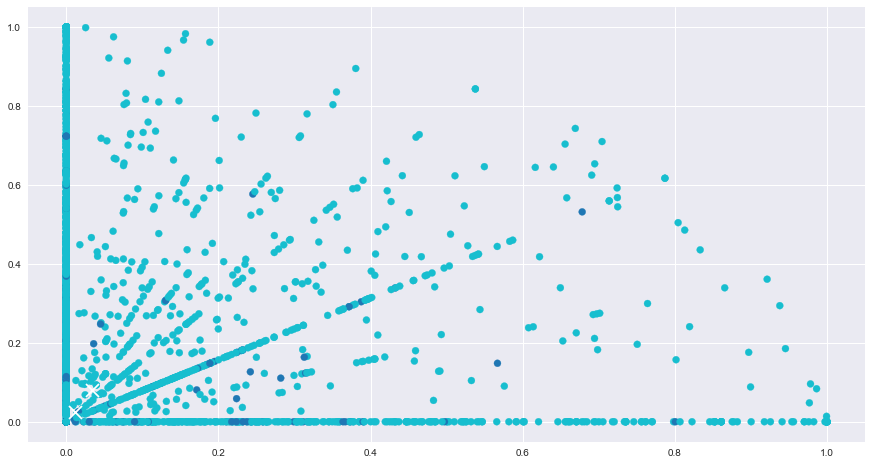

In [62]:
plt.figure(figsize=(15,8))
plt.style.use('seaborn')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.scatter(tdidf[:,0], tdidf[:,1], c=km_labels,cmap='tab10')

In [ ]:
printMetrics(true,kmeans)

In [ ]:
printClusters(vectorizer, kmeans.cluster_centers_.argsort(),2)

**MAX-Agglomerative Clustering**

In [ ]:
ag = sk_cluster.AgglomerativeClustering(linkage = 'complete', n_clusters = 2)   

ag_labels = ag.fit_predict(tdidf)

print ('\nPrinting cluster assignment:')
ag_labels 

In [ ]:
printMetrics(true,ag)

In [ ]:
printClusters(vectorizer,ag.cluster_centers_.argsort(),2)

**SSE-Agglomerative Clustering**

In [ ]:
ag = sk_cluster.AgglomerativeClustering(linkage = 'ward', n_clusters = 3)   

#complete: The maximum distances
#n_clusters: The number of clusters to find.

ag_labels = ag.fit_predict(tdidf)

print ('\nPrinting cluster assignment:')
ag_labels 

## 2.1: First, you apply the k-means algorithm. Create a plot of the SSE error of the k-means algorithm as a function of the number of clusters, for k up to 20, in order to determine the optimal number of clusters.


In [ ]:
error = np.zeros(20)
for k in range(1,20):
    kmeans = sk_cluster.KMeans(n_clusters=k, n_init=10, max_iter=300)
    kmeans.fit_predict(tdidf)
    error[k] = kmeans.inertia_

plt.plot(range(1, 20), error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

## 2.2: Run the k-means algorithm for the optimal number of clusters you identified in the last task. Print some hashtags/handles in each cluster. From the hashtags/handles in each cluster, try to deduce what is the topic it concerns. Include your conclusions in your report.

In [ ]:
kmeans = sk_cluster.KMeans(n_clusters=20, n_init=10, max_iter=300)
kmeans.fit_predict(tdidf)
printClusters2(vectorizer, kmeans.cluster_centers_.argsort(), 20)

In [ ]:
def printClusters2(vectorizer,cluster_centers,num_cluster):
    des_order_centroids = cluster_centers[:,::-1]     #  get the indices that sort array in descending order
    terms = vectorizer.get_feature_names()
    print ("All the terms:")
    print(terms, '\n')

    for i in range(num_cluster):
        print ("Cluster:", i)
        for ind in des_order_centroids[i, :5]:
            print (terms[ind])
        print()  
